<a href="https://colab.research.google.com/github/AkkshataGuptaa/TheNewGermanyFund_StockPricePrediction_BusinesscaseStudy_TimeSeriesAnalysis/blob/main/TheNewGermanyFund_StockPricePrediction_BusinesscaseStudy_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE - This is a guided project by builtin with some modifications.

In [125]:
# Importing relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt  # importing Time-series models and methods
import statsmodels.api as sm       # importing Cross-sectional models and methods
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook     # progressbar decorator for iterators -  tqdm is a Python module that allows you to create and customize progress bars and meters for loops, iterables, and file operations.
# Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you’re done!

from itertools import product  # Python’s Itertool is a module that provides various functions that work on iterators to produce complex iterators.

import warnings
warnings.filterwarnings('ignore')

# to display and store Matplotlib plots within a Python Jupyter notebook
%matplotlib inline

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

!pip install qis    #Quantitative Investment Strategies: QIS package implements analytics for visualisation of financial data, performance reporting, analysis of quantitative strategies.


**Notes:**
1. Auto-correlation
2. Seasonality
3. Stationary
- Dickey-Fuller test to determine if a time series is stationary or not
- Ho : Unit root = 0 (Process is NOT Stationary)
- Ha : Unit root != 0 (Process is Stationary)
- If unit root is present, then p > 0, and the process is not stationary.
  Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary.

4. There are many ways to model a time series in order to make predictions. The most popular ways include:

- Moving average.
- Exponential smoothing.
- Double exponential smoothing.
- Triple exponential smoothing.
- Seasonal autoregressive integrated moving average (SARIMA.)


5. **Quantitative Investment Strategies**: QIS package implements analytics for visualisation of financial data, performance reporting, analysis of quantitative strategies.

qis package is split into 5 main modules with the dependecy path increasing sequentially as follows.

>1. **qis.utils** is module containing low level utilities for operations with pandas, numpy, and datetimes.

>2. **qis.perfstats** is module for computing performance statistics and performance attribution including returns, volatilities, etc.

>3. **qis.plots** is module for plotting and visualization apis.

>4. **qis.models** is module containing statistical models including filtering and regressions.

>5. **qis.portfolio** is high level module for analysis, simulation, backtesting, and reporting of quant strategies.

**qis.examples and qis.examples.performances** contains scripts with illustrations of QIS analytics.

# ***Loading Data***

In [126]:
!wget https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv -O stock_prices_sample.csv

--2024-07-28 11:06:53--  https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153396 (150K) [text/plain]
Saving to: ‘stock_prices_sample.csv’

stock_prices_sample 100%[===================>] 149.80K  --.-KB/s    in 0.01s   

2024-07-28 11:06:54 (10.6 MB/s) - ‘stock_prices_sample.csv’ saved [153396/153396]



In [129]:
# importing data into google collab and saving it in DataFrame 'data'
DATAPATH = 'https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv'

df = pd.read_csv(DATAPATH, index_col=['DATE'], parse_dates=['DATE'])
df.head(10)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.2300,47.3700,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.1400,46.4800,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.1600,46.4100,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.8700,18.8700,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.7900,18.8100,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
2018-06-01,GF,BBG000C3C6S2,EOD,daily,18.58,18.7600,18.5800,18.7400,17468.0,18.580000,18.760000,18.580000,18.740000,17468.0,NaN,0.0,1.0
2018-05-31,GF,BBG000C3C6S2,EOD,daily,18.52,18.5200,18.3012,18.4900,22384.0,18.520000,18.520000,18.301200,18.490000,22384.0,NaN,0.0,1.0
2018-05-30,GF,BBG000C3C6S2,EOD,daily,18.47,18.6780,18.4700,18.6500,22633.0,18.470000,18.678000,18.470000,18.650000,22633.0,NaN,0.0,1.0
2018-05-29,GF,BBG000C3C6S2,EOD,daily,18.51,18.5100,18.1500,18.2562,67412.0,18.510000,18.510000,18.150000,18.256200,67412.0,NaN,0.0,1.0


# ***1. Problem Statement and Exploratory Data Analysis***

**Define Problem Statement and perform Exploratory Data Analysis**

* Definition of problem
* Observations on dataset
* Univariate Analysis
* Bivariate Analysis
* Insights based on EDA

## ***Problem Statement:***

Predict the closing price  of the New Germany Fund (GF) in the next five trading days using their historical stock prices.

## ***Observation on dataset***

In [130]:
# Creating a function to inspect various aspects of the raw data

from tabulate import tabulate

def data_inspection(df):
  '''
  Description: This function returns basic details about the dataset to perform data inspection:
               1) Rows and columns of the DataFrame
               2) General information about the DataFrame
               3) Number of NULL or missing values in the DataFrame in each column.
  '''
  print("(Rows,Columns) of DataFrame: ",df.shape)  # shape of the data
  print("********************************************************************************")
  print("General Information: \n",tabulate(df.info()))   # general info about the data
  print("********************************************************************************")
  print("# null values in Features: \n\n",df.isnull().sum())     # Number of null values on each column of the data
  print("********************************************************************************")
  #print("Data Statistics (Numerical data): \n",tabulate(df.describe()))   # returns statistical summary of numerical data
  #print("********************************************************************************")
  #print("Data Statistics (Categorical data): \n",tabulate(df.describe(include = object)))   # returns statistical summary of categorical data
  #print("********************************************************************************")

In [131]:
# Function to identify unique value and counts for discrete or categorical data and min max value for continous numerical data

def unique_data(df):
    '''
    Description: unique_data(df) prints unique values and counts present in columns.
                 Features are divided into:
                 Discrete features - Numerical features with less than 10 unique values
                 Continuous features - Numerical features with more than 10 unique values
                 Categorical features - With data type as object

    Input:       The DataFrame for which unique values are required to be printed

    Output:      - Prints value_counts() for Discrete Numerical and Categorcial Features and Min, Max values for Continuous Numerical Features
                 - Returns the list of categorical_features, discrete_features, continuous_features in that order
    '''
    discrete_features = []
    continuous_features = []
    categorical_features = []

    # Iterate through each column in the DataFrame
    for feature in df.columns:
      if df[feature].dtype == object:
        categorical_features.append(feature)
      elif df[feature].nunique() <= 10:
        discrete_features.append(feature)
      else:
        continuous_features.append(feature)

    # Unique values for Discrete Numerical features
    for ft in discrete_features:
      print("Unique values for ", df[ft].value_counts())            # Print the unique values and their counts
      print("********************************************************")  # Print a separator

    # Unique values for Continuous Numerical features
    for ft in continuous_features:
      print(f" (Min,Max) for {ft}: {df[ft].min(), df[ft].max()}")           # Print the unique values and their counts
      print("********************************************************")     # Print a separator

    # Unique values for Categorical non Numerical features
    for ft in categorical_features:
      print("Unique values for ", df[ft].value_counts())            # Print the unique values and their counts
      print("********************************************************")  # Print a separator

    return categorical_features, discrete_features, continuous_features

In [132]:
# Getting a comprehensive summary of the data
data_inspection(df)

(Rows,Columns) of DataFrame:  (999, 17)
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2013-01-04 to 2014-06-23
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TICKER       999 non-null    object 
 1   FIGI         999 non-null    object 
 2   TYPE         999 non-null    object 
 3   FREQUENCY    999 non-null    object 
 4   OPEN         999 non-null    float64
 5   HIGH         999 non-null    float64
 6   LOW          999 non-null    float64
 7   CLOSE        999 non-null    float64
 8   VOLUME       999 non-null    float64
 9   ADJ_OPEN     999 non-null    float64
 10  ADJ_HIGH     999 non-null    float64
 11  ADJ_LOW      999 non-null    float64
 12  ADJ_CLOSE    999 non-null    float64
 13  ADJ_VOLUME   999 non-null    float64
 14  ADJ_FACTOR   7 non-null      float64
 15  EX_DIVIDEND  999 non-null    float64

In [133]:
# statistical summary of numerical data
df.describe()

,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,7.000000,999.000000,999.0
mean,15.992445,16.085008,15.911813,16.009216,24685.998999,13.517457,13.594784,13.449917,13.531783,24685.998999,0.937784,0.007414,1.0
std,2.725925,2.758512,2.716642,2.747702,23371.181517,3.065840,3.090487,3.054719,3.080369,23371.181517,0.061582,0.123297,0.0
min,12.240000,12.350000,12.020000,12.290000,1138.000000,9.195423,9.604877,9.195423,9.453297,1138.000000,0.801460,0.000000,1.0
25%,14.060000,14.120000,13.983000,14.060000,11156.500000,11.671802,11.733718,11.611366,11.660361,11156.500000,0.942977,0.000000,1.0
50%,15.380000,15.450100,15.300000,15.400000,18178.000000,12.253348,12.337322,12.197654,12.284556,18178.000000,0.962915,0.000000,1.0
75%,17.533400,17.604500,17.485050,17.555000,30106.000000,15.502341,15.565372,15.474493,15.539473,30106.000000,0.968239,0.000000,1.0
max,46.430000,47.619800,46.230000,47.370000,248000.000000,38.617027,39.606614,38.450681,39.398849,248000.000000,0.977677,3.535000,1.0


In [134]:
# statistical summary of categorical data
df.describe(include = object)

,TICKER,FIGI,TYPE,FREQUENCY
count,999,999,999,999
unique,2,2,2,1
top,GF,BBG000C3C6S2,EOD,daily
freq,996,996,998,999


In [135]:
# Unpacking different column types and printing unique values for each column
ft_cat, ft_num_dis, ft_num_con = unique_data(df)

Unique values for  ADJ_FACTOR
0.964035    1
0.962915    1
0.941895    1
0.972444    1
0.944060    1
0.977677    1
0.801460    1
Name: count, dtype: int64
********************************************************
Unique values for  EX_DIVIDEND
0.0000    992
0.7148      1
0.7433      1
0.7958      1
0.3873      1
0.8669      1
0.3635      1
3.5350      1
Name: count, dtype: int64
********************************************************
Unique values for  SPLIT_RATIO
1.0    999
Name: count, dtype: int64
********************************************************
 (Min,Max) for OPEN: (12.24, 46.43)
********************************************************
 (Min,Max) for HIGH: (12.35, 47.6198)
********************************************************
 (Min,Max) for LOW: (12.02, 46.23)
********************************************************
 (Min,Max) for CLOSE: (12.29, 47.37)
********************************************************
 (Min,Max) for VOLUME: (1138.0, 248000.0)
**********************

**Comments:**
* Data has 999 sample, and 17 features.
* Null values present only for ADJ_FACTOR column (992)
* Frequency of data is daily, and SPLIT_RATIO is 1 for all entries.
* (Min,Max) for OPEN: (12.24, 46.43)
* (Min,Max) for HIGH: (12.35, 47.6198)
* (Min,Max) for LOW: (12.02, 46.23)
* (Min,Max) for CLOSE: (12.29, 47.37)
* (Min,Max) for VOLUME: (1138.0, 248000.0)
* DATE is an index as opposed to a column

**Action:**
1. There are few entries of different stock than the New Germany Fund (GF) - ***Remove those***
2. There are entired concerning intraday information, but we only want end of day (EOD) information. - ***Remove irrelevant information.***
3. ***Remove unwanted columns*** as we need to solely focus on closing price.
'SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI'
4. DATE index can be converted to a column by doing ***reset_index*** to be able to perform trend analysis.


## ***Data Cleaning***

In [136]:
# Obtaining shape of dataset
df.shape

(999, 17)

In [137]:
# Removing entries of GEF stock and entries for intraday datatype
df = df[df.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']

In [138]:
# Drop unwanted columns not required for closing price prediction
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


In [139]:
df.shape

(995, 5)

**NOTE** - The sample stock price data includes stock values from 2014 to 2018. But since there has been a regime shift after 2020 due to Covid, Ukraine war hence using data from 2020 to train the model and make recent stock price predictions for GF fund.

**The decline in the New Germany Fund (GF) stock price after 2021 can be attributed to several factors:**

* **Economic Environment**: The broader economic challenges in Europe, including slow economic growth, inflation concerns, and fluctuating interest rates, have impacted investor sentiment towards European equities, including those held by the New Germany Fund​ (Seeking Alpha)​​ (FinViz)​.

* **Sector Performance**: The fund's performance is heavily tied to the German market and specific sectors such as manufacturing and technology. Germany's manufacturing sector has faced headwinds, including supply chain disruptions and lower demand, which have negatively impacted the fund's holdings​ (FinViz)​.

* **Geopolitical Risks**: Geopolitical events, including the ongoing conflict in Ukraine and its economic ramifications for Europe, have added uncertainty and risk to the market, leading to cautious investment strategies and sell-offs in funds like the New Germany Fund​ (Seeking Alpha)​.

* **Fund-Specific Issues**: The fund itself has faced specific challenges, such as changes in management, adjustments in portfolio strategy, and distribution policies, which can affect its attractiveness to investors​ (FinViz)​.

Overall, these combined factors have contributed to the decline in the New Germany Fund's stock price since 2021.



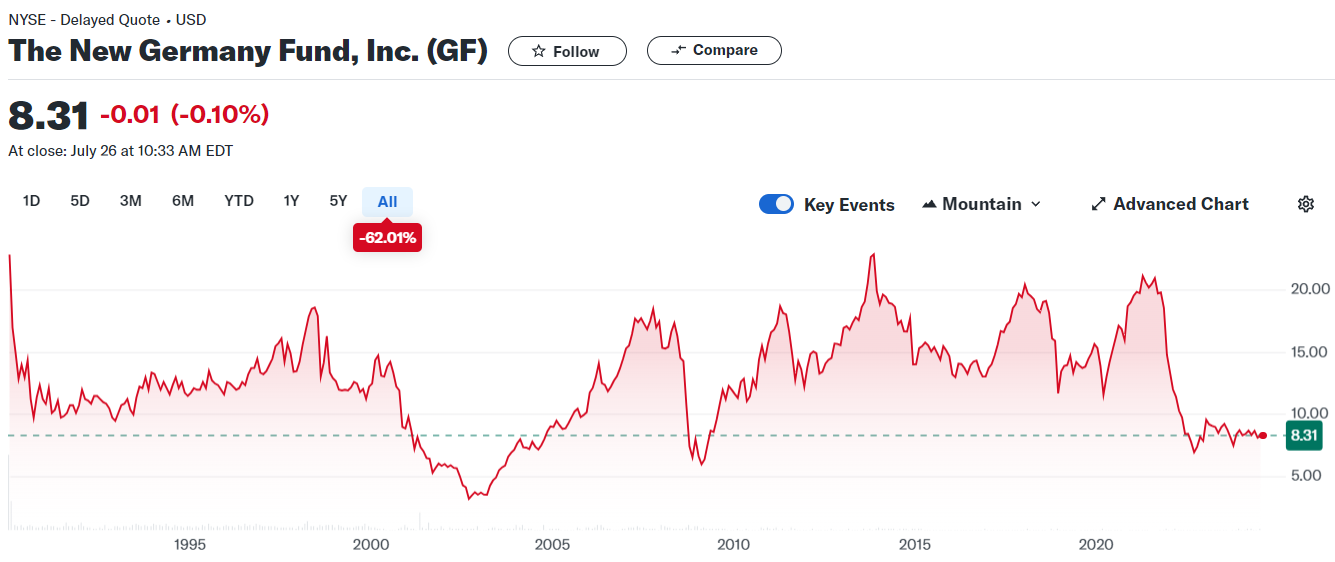




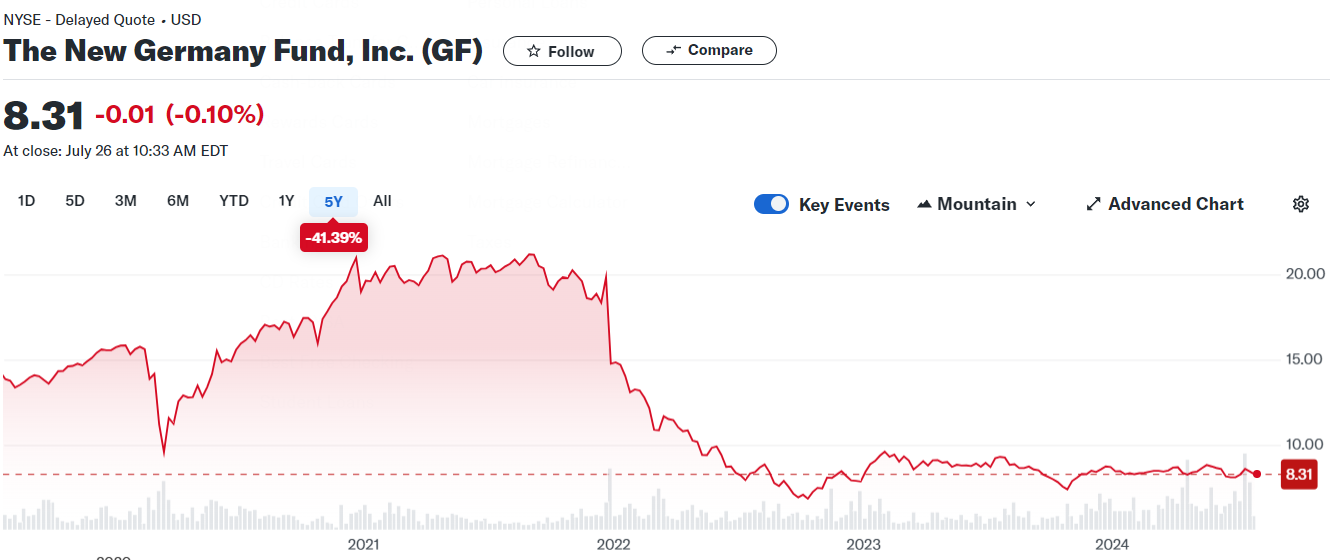


In [140]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

In [141]:
#Loading 5 years of latest data for the GF Fund

start_date = '2020-01-01'
end_date = '2023-12-31'

# Using Ticker module to download financial data for GF from Yahoo Finance.
gf = yf.Ticker("GF")
df = gf.history(period="5y")  # Period must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-29 00:00:00-04:00,9.011737,9.018065,9.011737,9.018065,7000,0.0,0.0
2019-07-30 00:00:00-04:00,8.916810,8.916810,8.796569,8.796569,14000,0.0,0.0
2019-07-31 00:00:00-04:00,8.840867,8.929465,8.815553,8.828210,29500,0.0,0.0
2019-08-01 00:00:00-04:00,8.859853,8.897824,8.834539,8.834539,18600,0.0,0.0
2019-08-02 00:00:00-04:00,8.828211,8.847197,8.771255,8.796569,28500,0.0,0.0


In [142]:
# convert index type to DateTime
df.index = pd.to_datetime(df.index)

# convert index to a column
df.reset_index(inplace = True)

# Extract date from datetime
df['Date'] = df['Date'].dt.date

# convert Date column back to index
df.set_index("Date", inplace = True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-29,9.011737,9.018065,9.011737,9.018065,7000,0.0,0.0
2019-07-30,8.916810,8.916810,8.796569,8.796569,14000,0.0,0.0
2019-07-31,8.840867,8.929465,8.815553,8.828210,29500,0.0,0.0
2019-08-01,8.859853,8.897824,8.834539,8.834539,18600,0.0,0.0
2019-08-02,8.828211,8.847197,8.771255,8.796569,28500,0.0,0.0


In [143]:
# Drop unwanted columns not required for closing price prediction
drop_cols = ['Volume', 'Dividends', 'Stock Splits']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,Open,High,Low,Close
Date,,,,
2019-07-29,9.011737,9.018065,9.011737,9.018065
2019-07-30,8.916810,8.916810,8.796569,8.796569
2019-07-31,8.840867,8.929465,8.815553,8.828210
2019-08-01,8.859853,8.897824,8.834539,8.834539
2019-08-02,8.828211,8.847197,8.771255,8.796569


In [144]:
df.shape
# 1258 records

(1258, 4)

## ***Train Test Split***

Training Data - Till 2023

Testing Data - From 2024

In [145]:
# testing data
df_test = df.iloc[1115:,:]

# training data
df = df.iloc[:1115,:]

In [146]:
print(df.shape)
df.tail(2)

(1115, 4)


,Open,High,Low,Close
Date,,,,
2023-12-28,8.725917,8.77578,8.686027,8.705972
2023-12-29,8.725917,8.77578,8.696000,8.715944


In [147]:
print(df_test.shape)
df_test.head(2)

(143, 4)


,Open,High,Low,Close
Date,,,,
2024-01-02,8.586303,8.705972,8.586303,8.676055
2024-01-03,8.546413,8.546413,8.416770,8.466633


## ***Define MAPE - Mean Absolute Percentage Error***

In [148]:
# Define MAPE - To be used as our error metric
# MAPE is lower the better

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## ***EDA - Univariate Analysis***

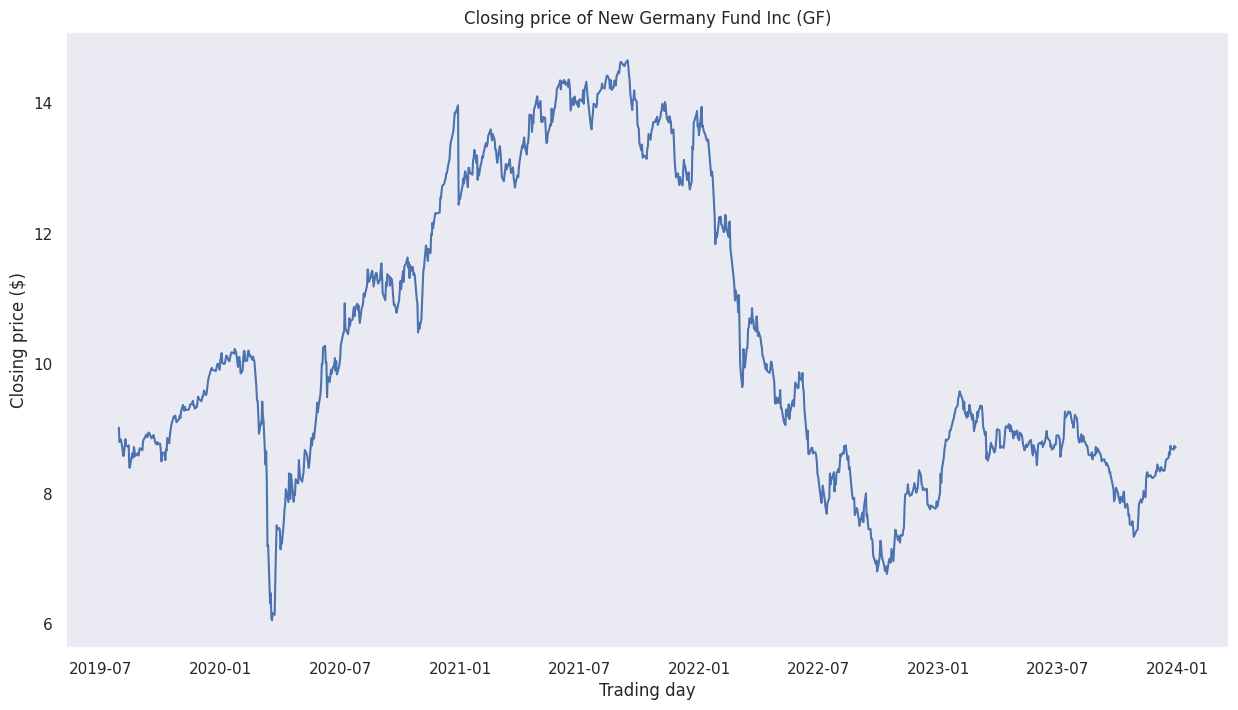

In [149]:
# Plot closing price

plt.figure(figsize=(15, 8))
plt.plot(df.Close)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

**Comments:**
* This is not a stationary process
* Hard to comment of seasonality of the data
* There appears to be auto correlation because of the sinusoidal pattern observed for closing prices from 2014 to 2018

In [150]:
# Creating a deep copy of original data
data = df.copy()

In [151]:
data = data.reset_index()
data.head()

,Date,Open,High,Low,Close
0,2019-07-29,9.011737,9.018065,9.011737,9.018065
1,2019-07-30,8.916810,8.916810,8.796569,8.796569
2,2019-07-31,8.840867,8.929465,8.815553,8.828210
3,2019-08-01,8.859853,8.897824,8.834539,8.834539
4,2019-08-02,8.828211,8.847197,8.771255,8.796569


In [152]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1115 entries, 0 to 1114
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
1115 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.8 KB


In [153]:
# Extract Year and Month from DATE column
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data.head()

,Date,Open,High,Low,Close,Year,Month
0,2019-07-29,9.011737,9.018065,9.011737,9.018065,2019,7
1,2019-07-30,8.916810,8.916810,8.796569,8.796569,2019,7
2,2019-07-31,8.840867,8.929465,8.815553,8.828210,2019,7
3,2019-08-01,8.859853,8.897824,8.834539,8.834539,2019,8
4,2019-08-02,8.828211,8.847197,8.771255,8.796569,2019,8


In [154]:
data['Date'].min(), data['Date'].max()

(Timestamp('2019-07-29 00:00:00'), Timestamp('2023-12-29 00:00:00'))

## ***EDA - Bivariate Analysis***

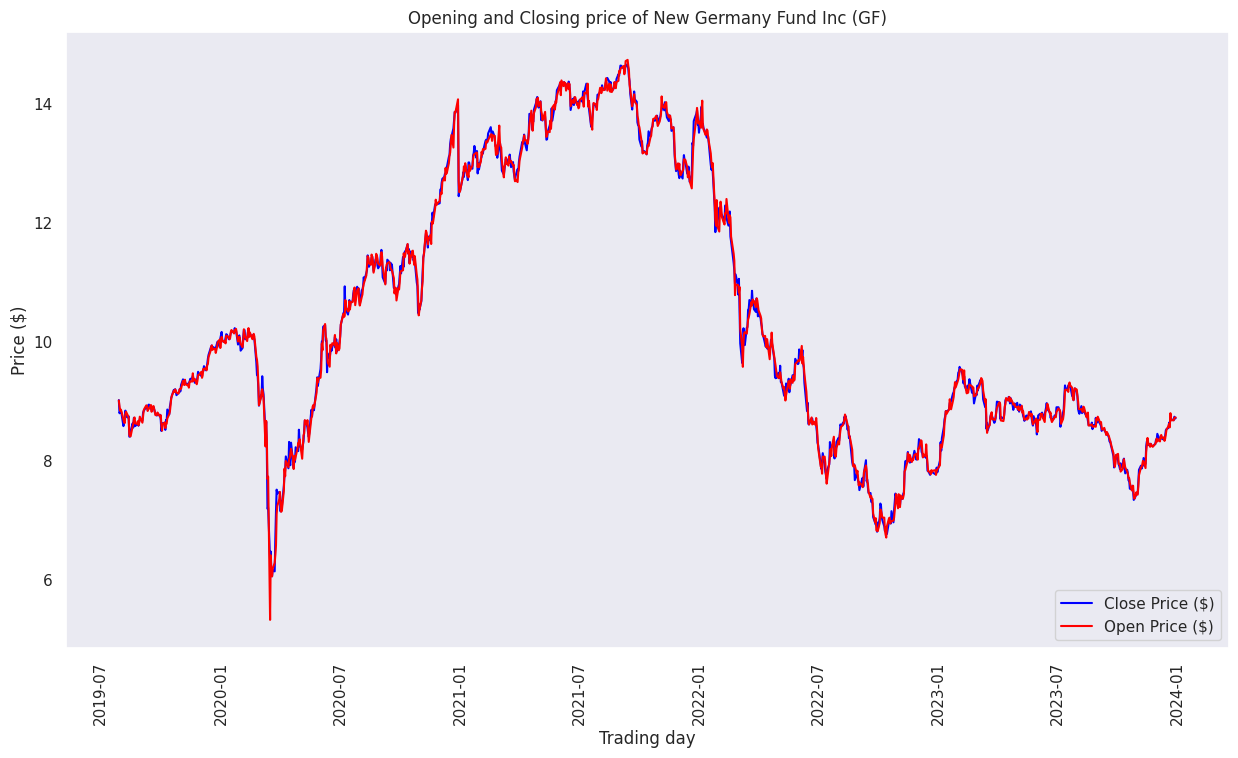

In [156]:
# Plot opening and closing price together

plt.figure(figsize=(15, 8))
plt.plot(df.Close, color = 'blue', label = "Close Price ($)")
plt.plot(df.Open, color = 'red', label = "Open Price ($)")
#plt.plot(df.HIGH, color = 'green', linestyle='dashed')
#plt.plot(df.LOW, color = 'orange', linestyle='dashed')
plt.title('Opening and Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Price ($)')
plt.xlabel('Trading day')
plt.legend(loc='lower right')
plt.xticks(rotation = 90)
plt.grid(False)
plt.show()

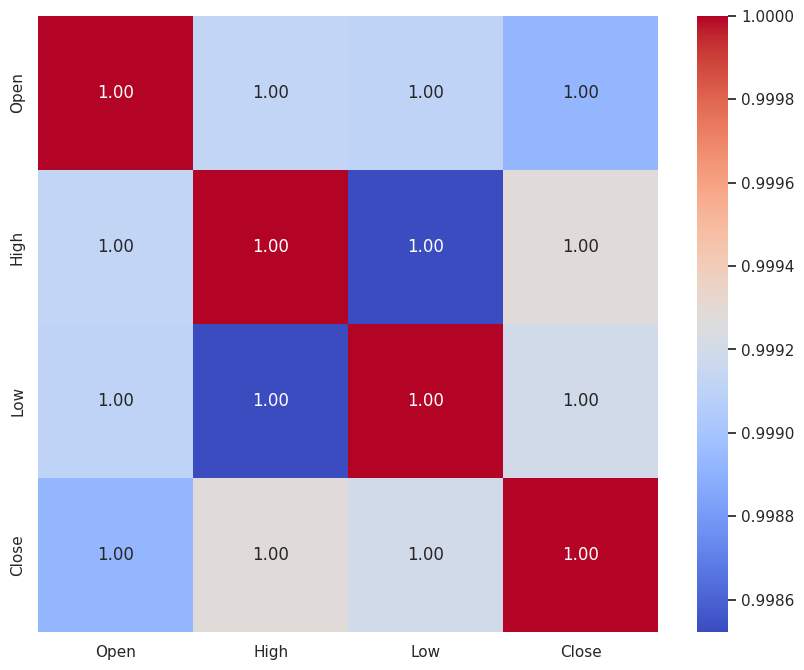

In [157]:
# Using heatmap to identify correlation between numerical data

import seaborn as sns

# Compute the correlation matrix for numerical features
correlation_matrix = df.select_dtypes(include=[np.number]).corr()  # Fill in the blank to compute correlation

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')  # Fill in the blank to plot the heatmap

# Show the plot
plt.show()

**Comments:**
* HIGH, LOW, CLOSE, OPEN all prices are highly correlated with each other, i.e. in the long term they move in the same direction even though there may be fluctuations in the short term.
* HIGH and CLOSE price are more correlated as compared to HIGH and OPEN, LOW and OPEN, CLOSE and OPEN, HIGH and LOW prices.

# ***2. Data Pre-processing (Data Preparation for Modelling)***

## ***Sorting Stock Price Data***

In [158]:
# Converting index to datetime and sorting it before performing moving average rolling window calculations
# This extra step is done because moving average is taken for historical data to predict future price - hence sorting the data in ascending order ensures rolling window is implemented correctly.
df.index = pd.to_datetime(df.index)
df.sort_index(ascending = True, inplace = True)
df.head(4)

,Open,High,Low,Close
Date,,,,
2019-07-29,9.011737,9.018065,9.011737,9.018065
2019-07-30,8.916810,8.916810,8.796569,8.796569
2019-07-31,8.840867,8.929465,8.815553,8.828210
2019-08-01,8.859853,8.897824,8.834539,8.834539


## ***Moving Average Model***

* Using the moving average model to smooth our time series.
* This that, we will rely on a helper function that will run the moving average model over a specified time window, and it will plot the result smoothed curve.

In [159]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    '''
    Description: plot_moving_average(series, window, plot_intervals=False, scale=1.96)
    series - DataFrame Series to be input into the model to calculate moving average values on
    window - Number of days for which the rolling window should be taken. 5 days window implies, future value = average value for last 5 days
    plot_intervals - For a longer rolling period, intervals need to be plotted hence this field can be marked as True
    scle - Hypothesis Testing, normalized z value for confidence intervals
    '''

    rolling_mean = series.rolling(window=window).mean()     # pandas.DataFrame.rolling() provides rolling window calculation
    #print(rolling_mean)

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])   # MAE(y_true, y_pred)
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)              # Lower bound for confidence interval
        upper_bound = rolling_mean + (mae + scale * deviation)              # Upper bound for confidence interval
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

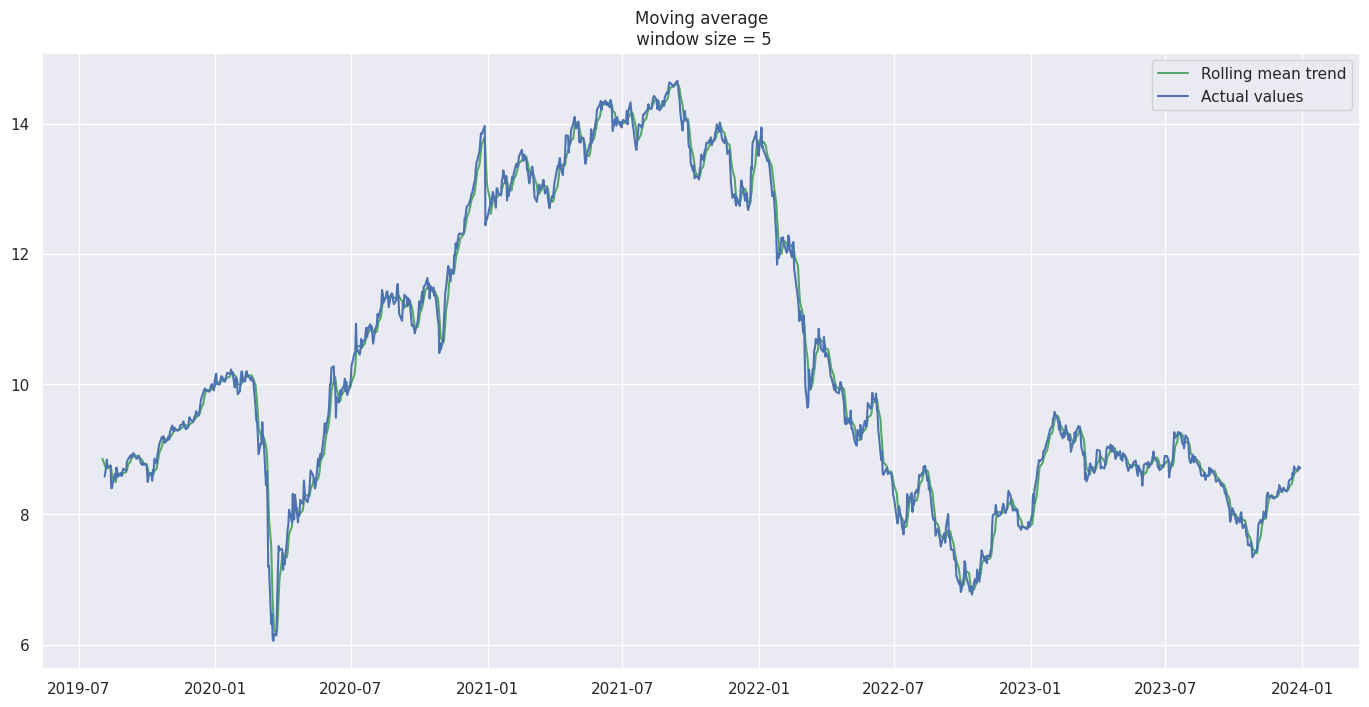

In [160]:
#Smooth by the previous 5 days (by week)
plot_moving_average(df.Close, 5)

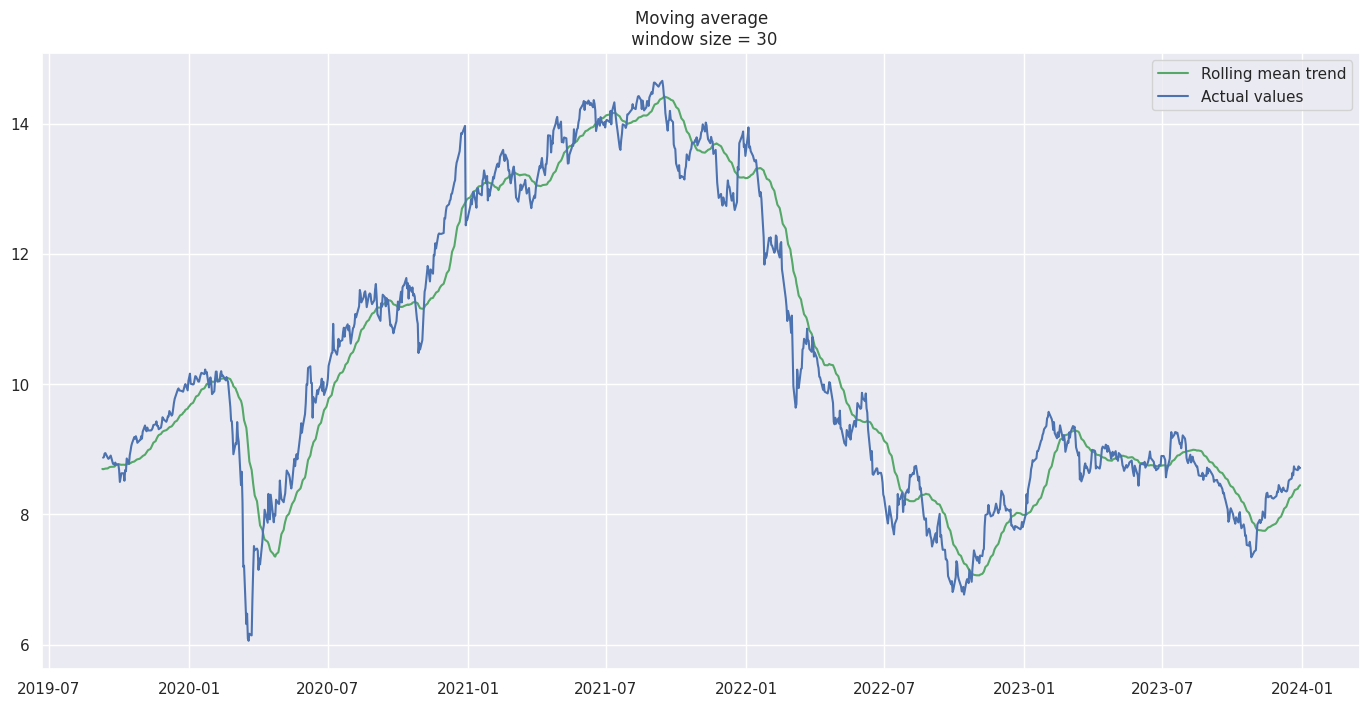

In [161]:
#Smooth by the previous month (30 days)
plot_moving_average(df.Close, 30)

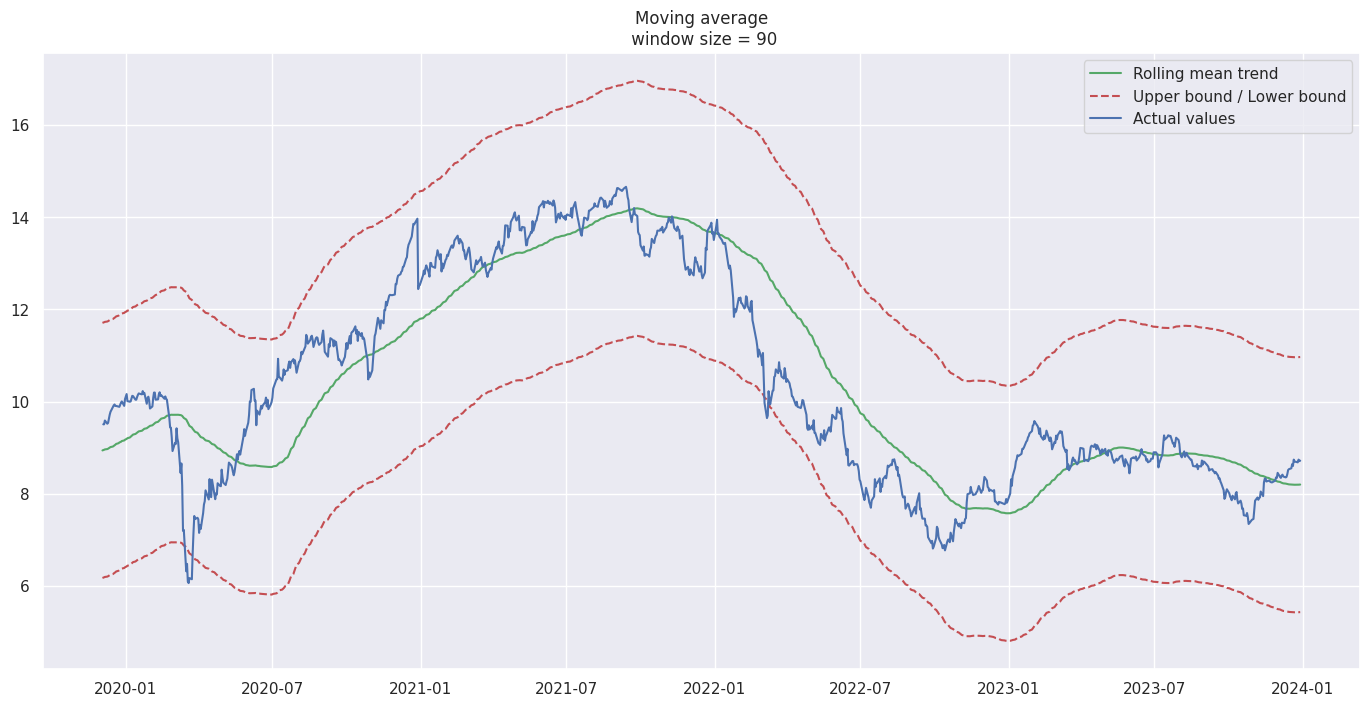

In [162]:
#Smooth by previous quarter (90 days)
plot_moving_average(df.Close, 90, plot_intervals=True)

In [163]:
data.sort_values(by = 'Date',ascending= True, inplace = True)
data.head(4)

,Date,Open,High,Low,Close,Year,Month
0,2019-07-29,9.011737,9.018065,9.011737,9.018065,2019,7
1,2019-07-30,8.916810,8.916810,8.796569,8.796569,2019,7
2,2019-07-31,8.840867,8.929465,8.815553,8.828210,2019,7
3,2019-08-01,8.859853,8.897824,8.834539,8.834539,2019,8


In [ ]:
# Adding a column Rolling Mean to understand the rolling calculation
data['Rolling_Mean'] = data.Close.rolling(window = 5).mean().values

In [166]:
data[['Date','Close', 'Rolling_Mean']].head(10)

,Date,Close,Rolling_Mean
0,2019-07-29,9.018065,NaN
1,2019-07-30,8.796569,NaN
2,2019-07-31,8.828210,NaN
3,2019-08-01,8.834539,NaN
4,2019-08-02,8.796569,8.854790
5,2019-08-05,8.581401,8.767458
6,2019-08-06,8.644685,8.737081
7,2019-08-07,8.726955,8.716830
8,2019-08-08,8.840867,8.718095
9,2019-08-09,8.739612,8.706704


**Comments:**
* 5-day window - We can hardly see a trend because it’s too close to the actual curve.
* 30-day and 90-day window - Trends are easier to spot now!
* ***The 30-day and 90-day trends show an upward curve at the end. This might mean that the stock is likely to go up in the following days.***


## ***Exponential Smoothing***

* Using this to see if we can observe a better trend

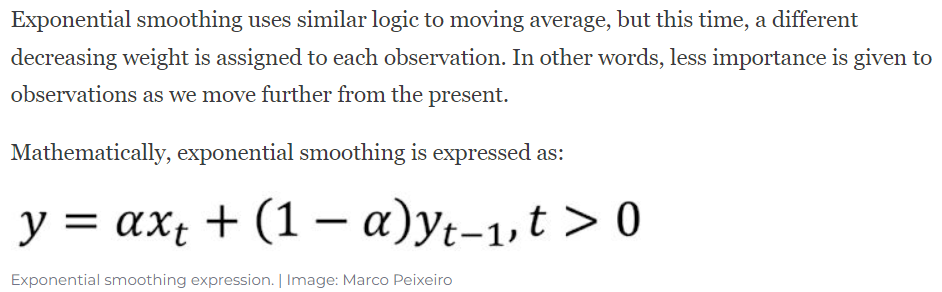

In [167]:
# Function to perform exponential smoothing
def exponential_smoothing(series, alpha):
    '''
    Description: exponential_smoothing(series, alpha)
    series - DataFrame Series to be input into the model to calculate moving average values on
    alpha - Smoothing factor that takes values between zero and one. It determines how fast the weight decreases for previous observations.
    '''
    # series --> y_true
    # result --> y_pred
    result = [series[0]]   # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Plot exponential smoothing
def plot_exponential_smoothing(series, alphas):
    '''
    Description: plot_exponential_smoothing(series, alphas)
    series - DataFrame Series to be input into the model to calculate moving average values on
    alpha - Smoothing factor that takes values between zero and one. It determines how fast the weight decreases for previous observations.
    '''
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

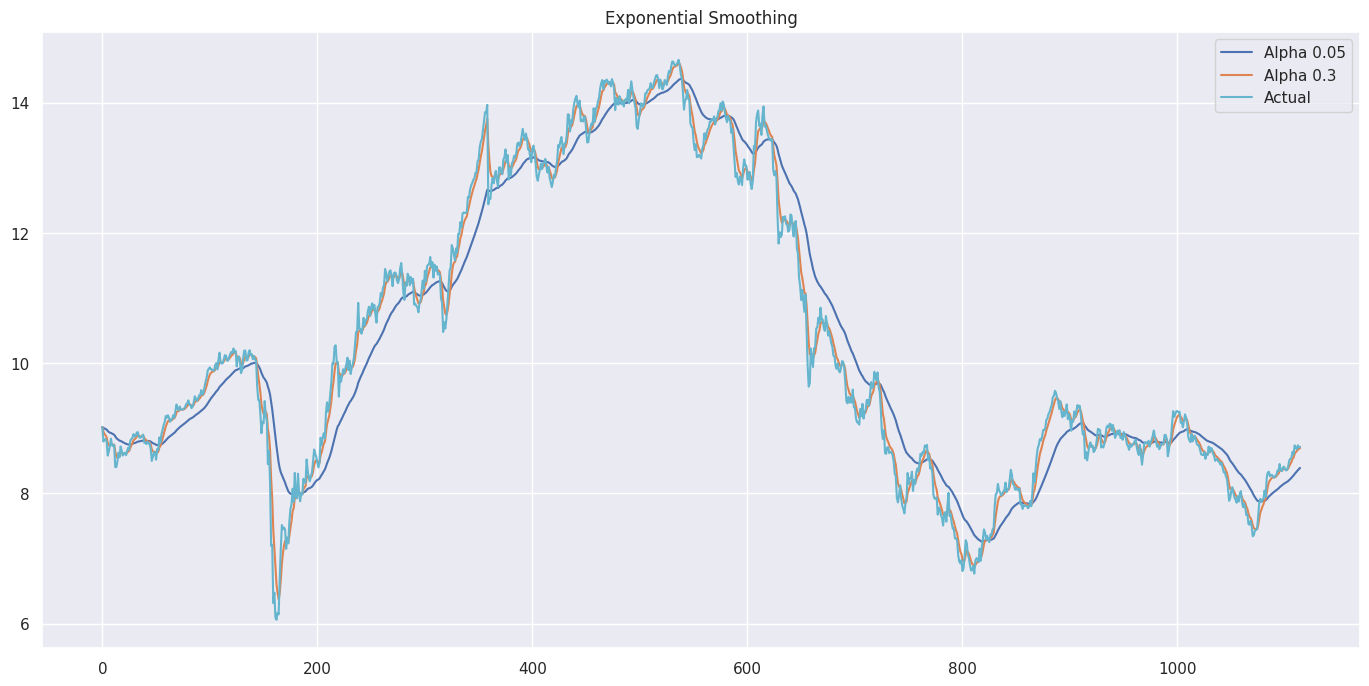

In [168]:
# Plotting exponential smoothing with alpha value of 0.05 and 0.3
plot_exponential_smoothing(df.Close, [0.05, 0.3])

**Comments:**
* An alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

## ***Double Exponential Smoothing***

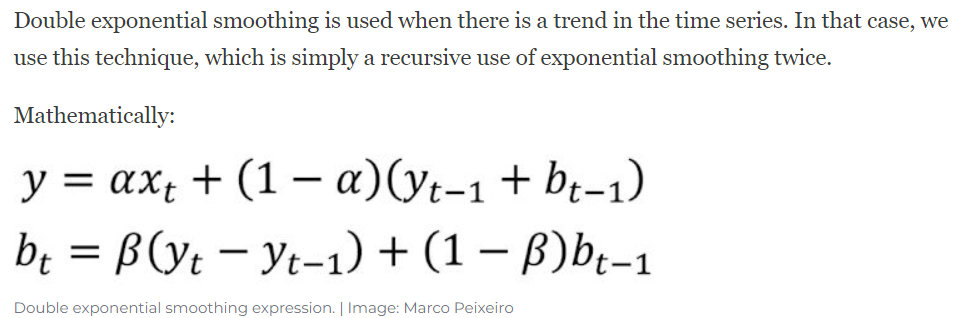

In [169]:
def double_exponential_smoothing(series, alpha, beta):
    '''
    Description: double_exponential_smoothing(series, alpha, beta)
    series - DataFrame Series to be input into the model to calculate moving average values on
    alpha - Smoothing factor that takes values between zero and one. It determines how fast the weight decreases for previous observations.
    beta - Beta is the trend smoothing factor, and it takes values between zero and one.
    '''
    # series --> y_true
    # result --> y_pred
    # level  --> yt
    # trend  --> bt
    # value  --> xt
    result = [series[0]]   # First value is same as series
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    '''
    Description: plot_double_exponential_smoothing(series, alphas, betas)
    series - DataFrame Series to be input into the model to calculate moving average values on
    alpha - Smoothing factor that takes values between zero and one. It determines how fast the weight decreases for previous observations.
    beta - Beta is the trend smoothing factor, and it takes values between zero and one.
    '''
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

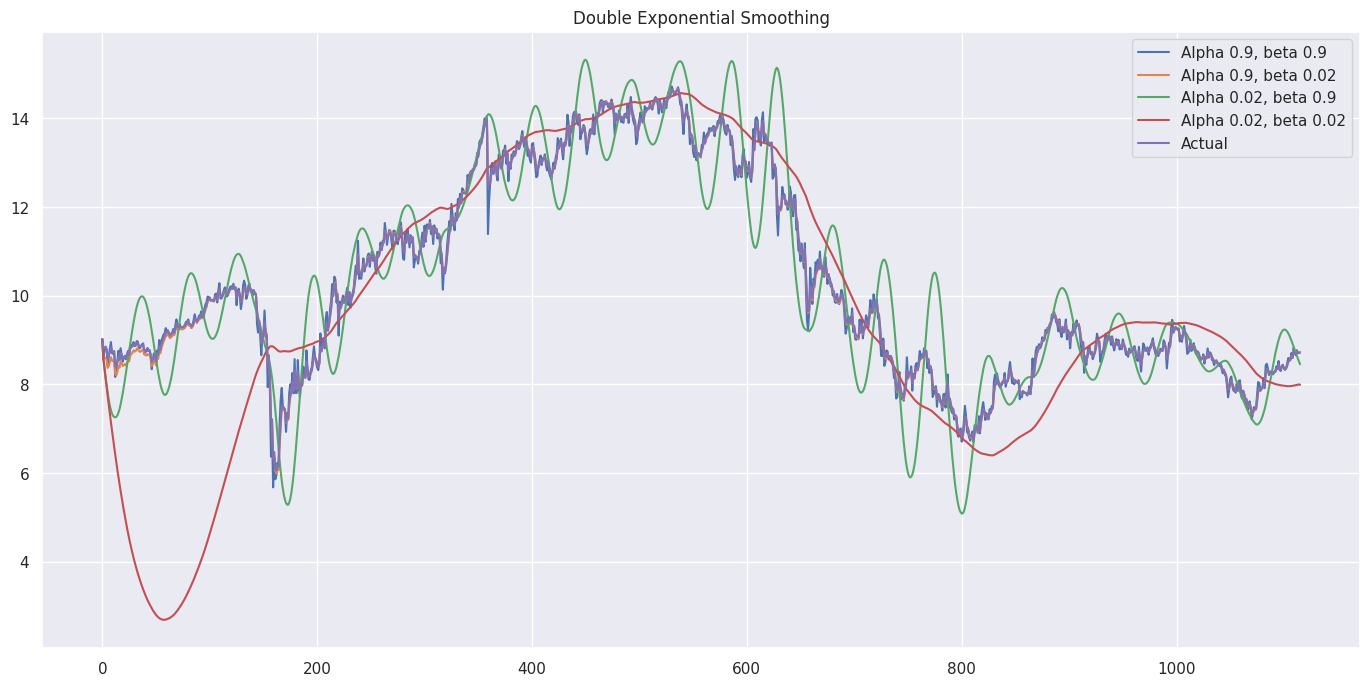

In [170]:
# Plot Closing prices using double exponential smoothing for different combinations of alpha and beta
plot_double_exponential_smoothing(df.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

**Comments:**
* Both alpha, beta low - Highly smoothened curve
* Both alpha, beta high - Cuvre very close to actual values
* Alpha high, beta low - Cuvre very close to actual values
* Alpha low, beta high - Smoothened curve with better fit than both being low.

## ***Data Preparation for Modelling***

* **Dickey-Fuller Test** to test Stationarity
* Convert data to Stationary using **First Difference**

### ***Stationary Data - Dickey-Fuller Test***

* We must turn our series into a stationary process in order to model it. Therefore, we need to apply the Dickey-Fuller test to see if it is a stationary process.
* The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [171]:
import statsmodels.api as sm       # importing Cross-sectional models and methods
import statsmodels.tsa.api as smt  # importing Time-series models and methods
from statsmodels.tsa.stattools import adfuller

# Performing Dickey-Fuller test
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    # If the data input is not a pandas Series then convert it into Series
    if not isinstance(y, pd.Series):      # The isinstance() function checks if the object (first argument) is an instance or subclass of classinfo class (second argument).
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)     # plotting the actual CLOSE price
        p_value = sm.tsa.stattools.adfuller(y)[1]   # Dickey_fuller test
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)   # Plot Auto Correlation
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)  # Plot partial Auto Correlation
        plt.tight_layout()

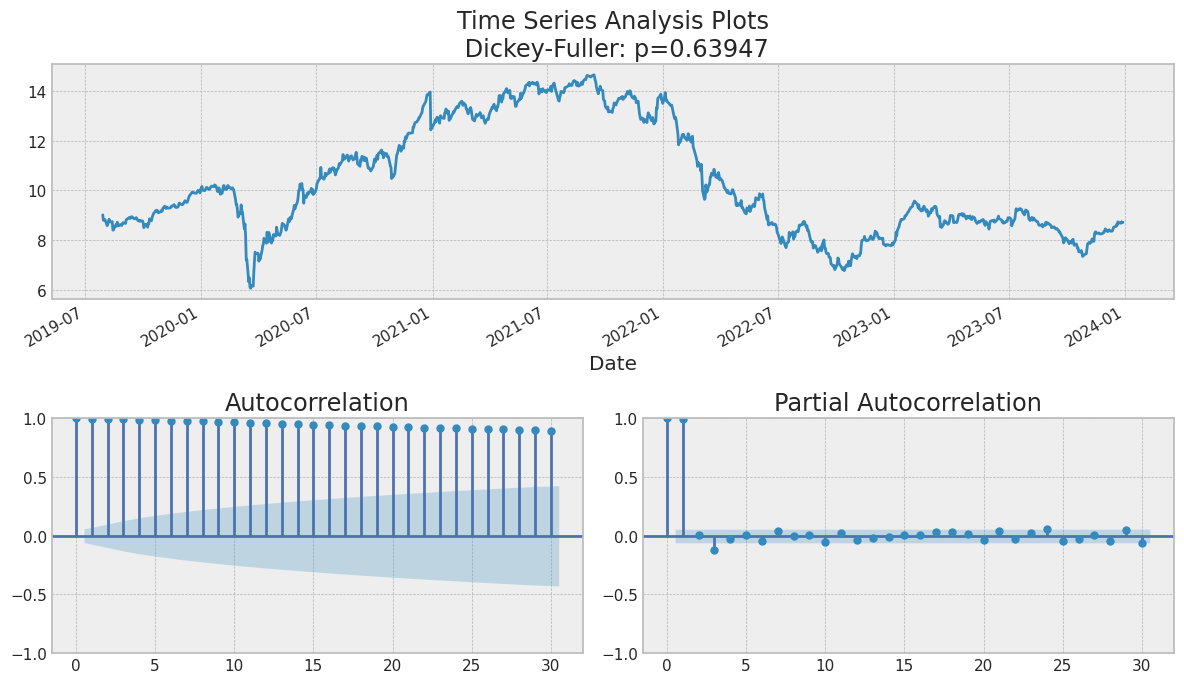

In [172]:
# Plotting the time series data to perform DF Test
tsplot(df.Close, lags=30)

**Comments:**

By the Dickey-Fuller test,
1. The time series is unsurprisingly non-stationary.
2. Looking at the autocorrelation plot, it is very high, and it seems that there is no clear seasonality.

### ***Make data Stationary - First Differencing***

* To get rid of the high autocorrelation and make the process stationary, take the first difference (i.e. we simply subtract the time series from itself with a lag of one day)

In [173]:
# Take the first difference to remove to make the process stationary
df_diff = df.Close - df.Close.shift(1)

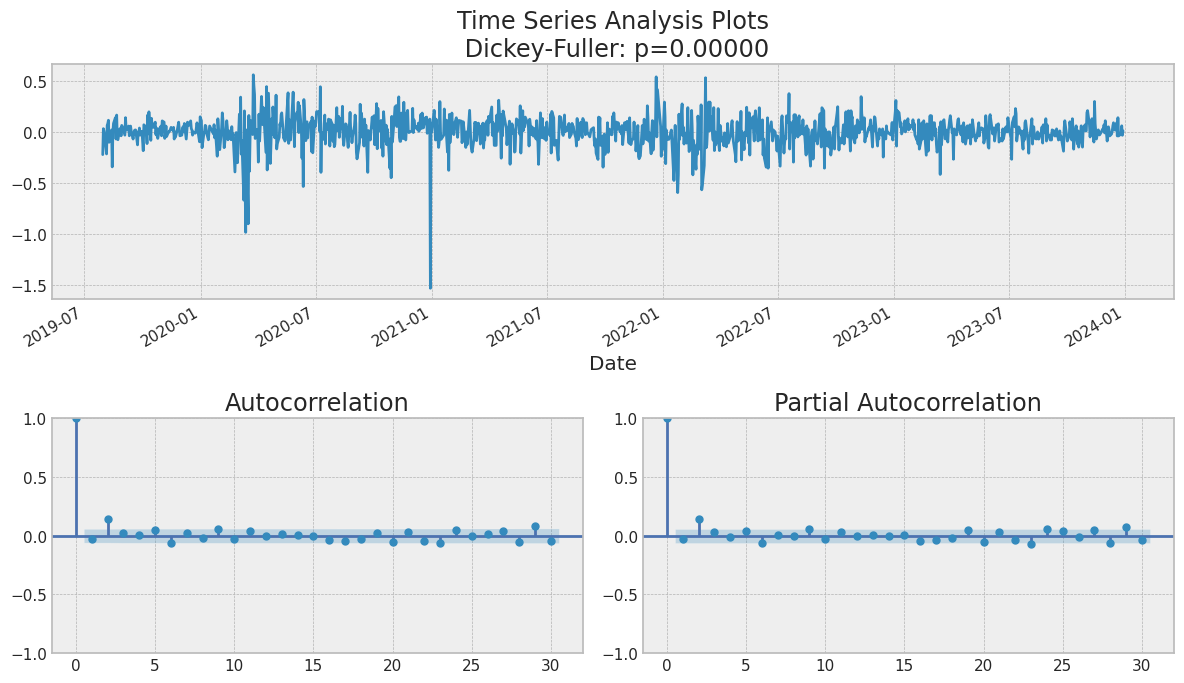

In [174]:
tsplot(df_diff[1:], lags=30)

**Comments:**
* Our series is now stationary and auto correlation is very low hence we can start modeling.

# ***3. Modelling***

## ***SARIMA***

**SARIMA (p, d, q)(P, D, Q, s)**

Before modeling with SARIMA, we must apply transformations to our time series to remove seasonality and any non-stationary behaviors.

>* **S - Seasonality** [ S(P, D, Q, s) - s is simply the seasons length | P and Q are the same as p and q, but for the seasonal component | D is the order of seasonal integration representing the number of differences required to remove seasonality from the series. ]
>* **AR - Auto Regression** [ AR(p) - p represents maximum lag for Regression model. ]
>* **I - Order of Integration** [ I(d) - d represents the number of differences required to make the series stationary. ]
>* **MA - Moving Average** [ MA(q) - q represents the biggest lag after which other lags are not significant on the autocorrelation plot. ]

1. We first need to define a few parameters and a range of values for other parameters to generate a list of all possible combinations of p, q, d, P, Q, D, s.
2. In the code below, we have 625 different combinations - We will train SARIMA with each combination to find the best-performing model. (This might take a while depending on computers processing power.)
3. Print summary of the model

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

**1. Hyper-parameter tuning of SARIMA model**

In [175]:
from itertools import product
from tqdm import tqdm_notebook     # Progress bar for loops, iterables, and file operations.
import statsmodels.tsa.api as smt  # importing Time-series models and methods
import statsmodels.api as sm       # importing Cross-sectional models and methods

# Set initial values and some bounds - 5*5*5*5 = 625 combinations or models trained
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

# Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)                 # from itertools - product is used to perform cartesian product, equivalent to a nested for-loop
                                                     # product('AB', repeat = 2) = AA AB BA BB
parameters_list = list(parameters)
print("Number of models trained: ", len(parameters_list))

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(data,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        data - Series to model
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    # If the data input is not a pandas Series then convert it into Series
    if not isinstance(data, pd.Series):      # The isinstance() function checks if the object (first argument) is an instance or subclass of classinfo class (second argument).
        data = pd.Series(data)

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):                 # SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
        try: model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic     # Akaike Information Criterion (AIC)

        # Save best model, AIC and parameters
        if aic < best_aic:       # Because smaller AIC score is preferable
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Number of models trained:  625


In [176]:
# Identify the best parameters for SARIMA model
result_table = optimize_SARIMA(df.Close , parameters_list, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

In [179]:
# Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]
print(p)
print(q)
print(P)
print(Q)

3
1
0
1


**2. Training SARIMA with the best parameters**

In [184]:
best_model = sm.tsa.statespace.SARIMAX(df.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

# This is already the best model, no need to fit it again
# gf = best_model.fit()

In [185]:
# Summary of the best model
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1115
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 514.873
Date:                           Sun, 28 Jul 2024   AIC                          -1017.746
Time:                                   14:05:22   BIC                           -987.678
Sample:                                        0   HQIC                         -1006.376
                                          - 1115                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9945      0.024    -41.492      0.000      -1.041      -0.947
ar.L2          0.1283      0.032      3.986

# ***4. Results Evaluation***

## ***MAPE***

In [201]:
# Get the first date in the index
start_date = df.index[0]

# Get predictions starting from the first date
predictions = best_model.get_prediction(start=start_date)

# Print the predictionspredictions.predicted_mean
print("Mean prediction: ", predictions.predicted_mean)

# How far is the predicted value from true value - Lower the better
print("\nMean Absolute Percentage Error (MAPE): ",mean_absolute_percentage_error(df.Close, best_model.predict(start=start_date, end=df.index[-1])))   #get_prediction

Mean prediction:  Date
2019-07-29    0.000000
2019-07-30    9.018065
2019-07-31    8.796569
2019-08-01    8.828210
2019-08-02    8.834539
                ...   
2023-12-22    8.749053
2023-12-26    8.702041
2023-12-27    8.701849
2023-12-28    8.713536
2023-12-29    8.731071
Name: predicted_mean, Length: 1115, dtype: float64

Mean Absolute Percentage Error (MAPE):  1.2268577725447867


## ***Mean Squared Error***

In [202]:
# Initialize lists to store evaluation metrics
mse_scores_train = []

# Calculate Mean Squared Error
mse = mean_squared_error(df["Close"], predictions.predicted_mean)
mse_scores_train.append(mse)
print("Mean Squared Error (MSE): ", mse)

Mean Squared Error (MSE):  0.11598121710690205


## ***Comparing Predicted Price to Actual Data***

Mean Squared Error (MSE):  0.0780203841291252

Mean Absolute Percentage Error (MAPE):  2.8321430010236246


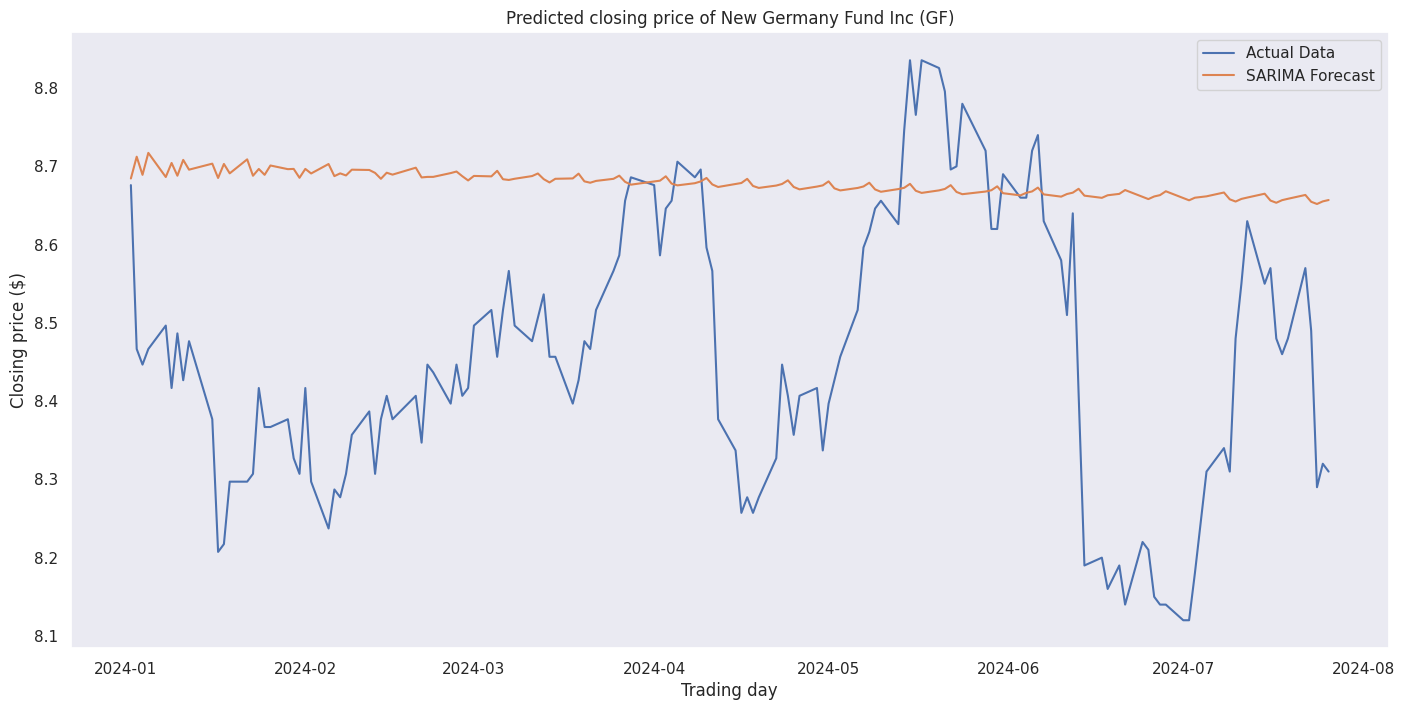

In [203]:
# Predicting closing price of GF Fund stock in 2024

# Initialize lists to store evaluation metrics
mse_scores = []

# Make predictions
forecast = best_model.get_forecast(steps=len(df_test))  # Forecast the next 12 periods
forecast_mean = forecast.predicted_mean
forecast_mean.index = df_test.index

# Calculate Mean Squared Error
mse = mean_squared_error(df_test["Close"], forecast_mean)
mse_scores.append(mse)
print("Mean Squared Error (MSE): ", mse)

# How far is the predicted value from true value - Lower the better
print("\nMean Absolute Percentage Error (MAPE): ",mean_absolute_percentage_error(df_test.Close, forecast_mean))   #get_prediction

# Plot the actual data and the forecast
plt.figure(figsize=(17, 8))
plt.plot(df_test['Close'], label='Actual Data')
plt.plot(forecast_mean, label='SARIMA Forecast')
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [204]:
best_model.aic

-1017.7456983428724

In [190]:
forecast_mean

1115    8.684530
1116    8.712357
1117    8.689187
1118    8.717242
1119    8.686414
          ...   
1260    8.650373
1261    8.653693
1262    8.655434
1263    8.660355
1264    8.651629
Name: predicted_mean, Length: 150, dtype: float64

**Comments:**
* Model appears to be predicting the trend of stock price movement well on recent actual data from the past 7 months of GF Fund stock price, however it does not predict short term movements in stock price that well.
* Model provides a smoothed curve highlighting the long term expected trend in the stock price.
* Model shows an downward trend for curve at the end for Test data (last 7 months data for GF Fund) - ***This incidates that stock is likely to go down in the following days***

# ***5. Actionable Insights and Recommendations***

## ***Dataset Summary***

* Data has 999 samples, and 17 features.
* Null values present only for ADJ_FACTOR column (992)
* Frequency of data is daily, and SPLIT_RATIO is 1 for all entries.
* (Min,Max) for OPEN: (12.24, 46.43)
* (Min,Max) for HIGH: (12.35, 47.6198)
* (Min,Max) for LOW: (12.02, 46.23)
* (Min,Max) for CLOSE: (12.29, 47.37)
* (Min,Max) for VOLUME: (1138.0, 248000.0)
* DATE is an index as opposed to a column

**Univariate analysis**
* Data is not a stationary process
* Hard to comment of seasonality of the data
* There appears to be auto correlation because of the sinusoidal pattern observed for closing prices from 2014 to 2018

**Bivariate Analysis**
* HIGH, LOW, CLOSE, OPEN all prices are highly correlated with each other, i.e. ***in the long term they move in the same direction even though there may be fluctuations in the short term.***
* HIGH and CLOSE price are more correlated as compared to HIGH and OPEN, LOW and OPEN, CLOSE and OPEN, HIGH and LOW prices.

**Moving Average Model**
* 5-day window - We can hardly see a trend because it’s too close to the actual curve.
* 30-day and 90-day window - Trends are easier to spot now!
* ***The 30-day and 90-day trends show an upward curve at the end. This might mean that the stock is likely to go up in the following days.***

**Exponential Smoothing**
* An alpha value of 0.05 smoothed the curve while picking up most of the upward and downward trends.

**Double Expotential Smoothing**
* Both alpha, beta low - Highly smoothened curve
* Both alpha, beta high - Cuvre very close to actual values
* Alpha high, beta low - Cuvre very close to actual values
* Alpha low, beta high - Smoothened curve with better fit than both being low.

**Dickey Fuller Test**

By the Dickey-Fuller test,
1. The time series is unsurprisingly non-stationary.
2. Looking at the autocorrelation plot, it is very high, and it seems that there is no clear seasonality.

**First Differencing**
* After performing first differencing, our data series is now stationary and auto correlation is very low hence we can start modeling.



## ***Model Summary***

**Best Fit model Performance Summary**
* No. Observations: 1115
* Log Likelihood: 514.873
* AIC: -1017.746
* BIC: -987.678
* HQIC: -1006.376
* MAPE: 1.227
* MSE: 0.116

**Model Performance on Test data (2024)**
* MSE: 0.078
* MAPE: 2.832

</br>

* Model appears to be predicting the trend of stock price movement well on recent actual data from the past 7 months of GF Fund stock price, however it does not predict short term movements in stock price that well.
* Model provides a smoothed curve highlighting the long term expected trend in the stock price.
* Model shows an downward trend for curve at the end for Test data (last 7 months data for GF Fund) - ***This incidates that stock is likely to go down in the following days***

**NOTE** - The sample stock price data includes stock values from 2014 to 2018. But since there has been a regime shift after 2020 due to Covid, Ukraine war hence using data from 2020 to train the model and make recent stock price predictions for GF fund.

**The decline in the New Germany Fund (GF) stock price after 2021 can be attributed to several factors:**

* **Economic Environment**: The broader economic challenges in Europe, including slow economic growth, inflation concerns, and fluctuating interest rates, have impacted investor sentiment towards European equities, including those held by the New Germany Fund​ (Seeking Alpha)​​ (FinViz)​.

* **Sector Performance**: The fund's performance is heavily tied to the German market and specific sectors such as manufacturing and technology. Germany's manufacturing sector has faced headwinds, including supply chain disruptions and lower demand, which have negatively impacted the fund's holdings​ (FinViz)​.

* **Geopolitical Risks**: Geopolitical events, including the ongoing conflict in Ukraine and its economic ramifications for Europe, have added uncertainty and risk to the market, leading to cautious investment strategies and sell-offs in funds like the New Germany Fund​ (Seeking Alpha)​.

* **Fund-Specific Issues**: The fund itself has faced specific challenges, such as changes in management, adjustments in portfolio strategy, and distribution policies, which can affect its attractiveness to investors​ (FinViz)​.

Overall, these combined factors have contributed to the decline in the New Germany Fund's stock price since 2021.



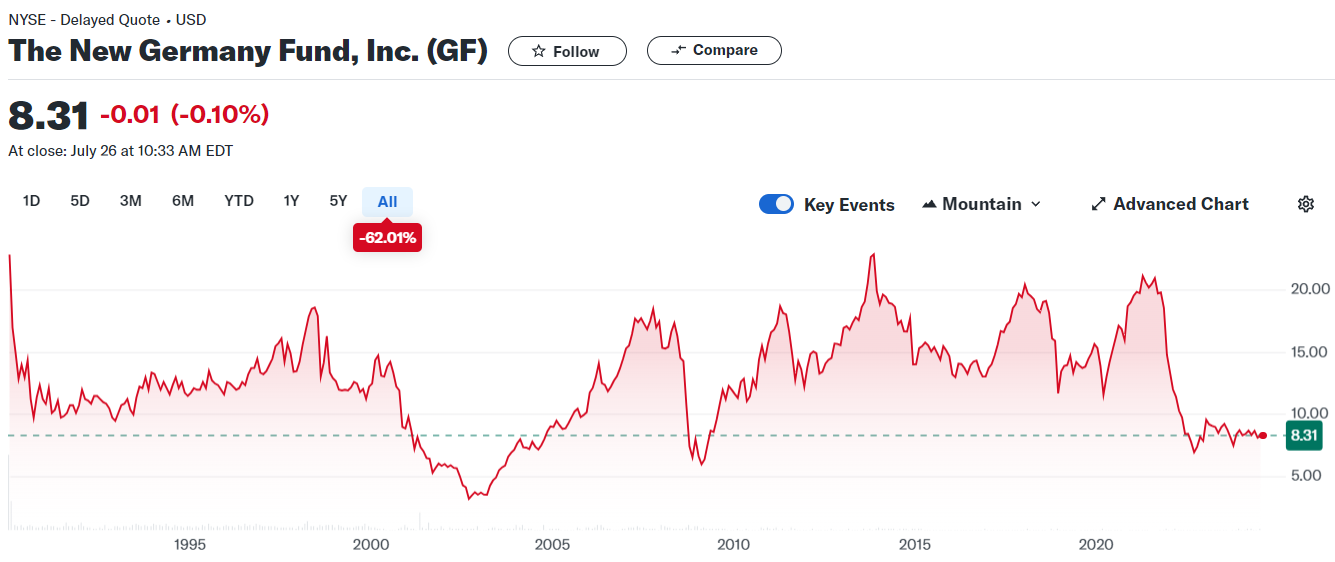




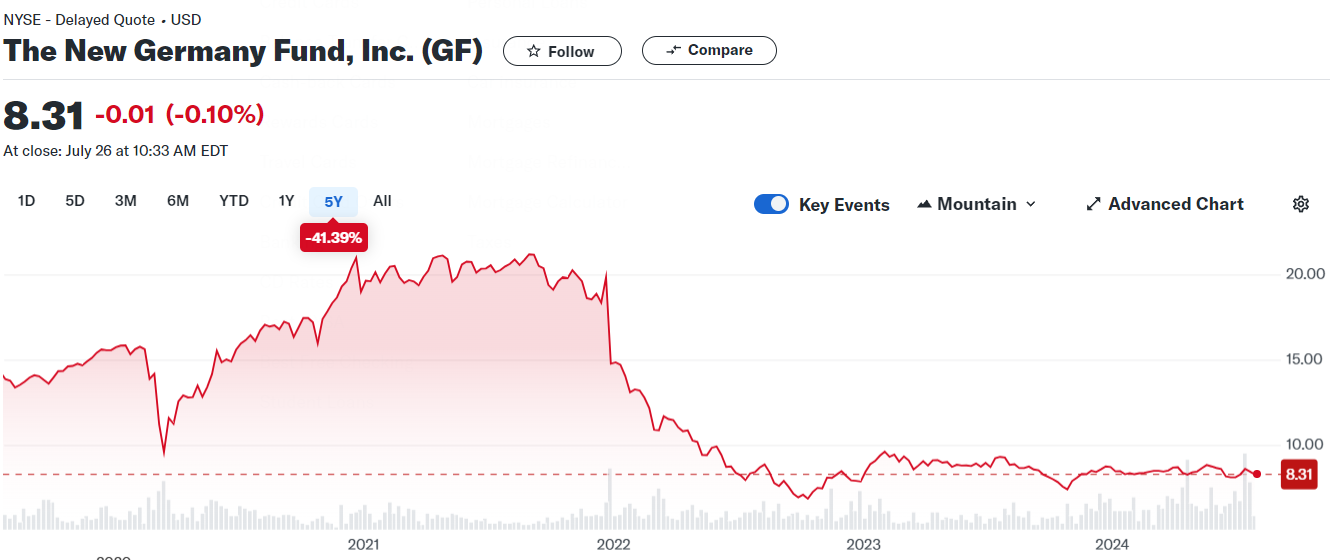


## ***Actionable Insights***

* Data was initially non-stationary, highly correlated (auto correlation present), and seasonality was not observable. - ***Tested using Dickey Fuller Test and First Differencing make the data stationary with low auto correlation. This is no clear seasonality***
* HIGH, LOW, CLOSE, OPEN all prices are highly correlated with each other, i.e. ***in the long term they move in the same direction even though there may be fluctuations in the short term - this is expected because in the long term fund is expected to grow at market rate (beta)***
* The 30-day and 90-day rolling window Moving Average trends show an upward curve at the end. ***This might mean that the stock is likely to go up in the following days in 2024 (historical data)***
* Model shows an downward trend for curve at the end for Test data (last 7 months data for GF Fund) - ***This incidates that stock is likely to go down in the following days***
* Model is predicting the long term trends decently on testing data (last 7 months) with MSE of 0.078 and MAPE of 2.832 as compared to Training data (2020 to 2023) with MSE 0f 0.116 and MAPE of 1.227

## ***Recommendation***

* As stock is expected to go down, it **could be given a sell recommendation** (based on model alone) however, there must be many other parameters that should be considered to make the buy / hold / sell recommendation for the stock.
* Since model appears to be correctly predicting long term movement in the stock prices, (as opposed to short term) it **can be used for long term investment. However, to guage long term movement, it is advisable to use Adj_Close instead of stock closing price to incorporate true value of the stock into analysis.**
* ***Be mindful of any regime changes while picking the time period for training the model or major event that resulted in fall of GF Fund stock prices over 2019 to 2024 and analyse if there is potential for GF fund stock price increasing in the long term based on Corporate Governance rating and other factors.***
* Linear Regression or other Regression models can also be used to perform stock price prediction.
* Since we have used a Univariate model based on Closing price of GF stock, model can be made more robust and reliable by incorporating additional factors like ***(thus using a Multi variate Time Series Model)***

1. **Historical Price Data**
   - **Closing Price:** The price at which a stock closed at the end of a trading day. - ALREADY CONSIDERED
   - **Open, High, Low Prices:** These prices provide detailed intraday trading information.
   - **Volume:** The number of shares traded during a given period.

2. **Technical Indicators**
   - **Moving Averages (MA):** Calculations of the average price over different periods. - ALREADY CONSIDERED
   - **Relative Strength Index (RSI):** Measures the speed and change of price movements.
   - **Moving Average Convergence Divergence (MACD):** Indicates the relationship between two moving averages.
   - **Bollinger Bands:** Provides a relative definition of high and low prices.
   - **Other Oscillators and Indicators:** Like Stochastic Oscillator, Average Directional Index (ADX), etc.

3. **Fundamental Data**
   - **Earnings Reports:** Quarterly and annual earnings information.
   - **Revenue, Profit Margins:** Indicators of a company’s financial health.
   - **P/E Ratio:** Price-to-Earnings ratio,

### ***Notes***

Both Linear Regression and Time Series models can be used for stock price prediction; however, they have different strengths and are suitable for different contexts.

### 1) **Linear Regression**
**Purpose:**
- **Prediction based on Relationships:** Linear Regression is used to predict the target variable (e.g., stock price) based on the linear relationship between the target and one or more predictor variables (features).

**Application in Stock Prediction:**
- **Feature Engineering:** This involves creating new features based on historical data, such as moving averages, volume, or even sentiment analysis from news articles.
- **Multi-Factor Models:** Incorporates several factors like technical indicators and fundamentals (P/E ratio, earnings, etc.) to predict stock prices.

**Strengths:**
- **Simplicity:** Easy to understand and implement.
- **Interpretability:** The coefficients give insight into the relationship between the predictor variables and the target variable.

**Limitations:**
- **Linearity Assumption:** Assumes a linear relationship, which may not capture the complex dynamics of stock prices.
- **Temporal Dependencies:** Doesn't explicitly account for temporal dependencies, which are crucial in stock predictions.


</br>

### 2) **Time Series Models**
**Purpose:**
- **Temporal Dependency and Trend Analysis:** Time Series models are designed to capture and predict patterns over time. These models take into account the sequential nature of the data.

**Common Time Series Models for Stock Prediction:**
- **ARIMA (Autoregressive Integrated Moving Average):** Combines autoregression, differencing, and moving average components.
- **SARIMA (Seasonal ARIMA):** Extends ARIMA to capture seasonality in data.
- **Exponential Smoothing:** Methods such as Holt-Winters can capture trends and seasonality.
- **GARCH (Generalized Autoregressive Conditional Heteroskedasticity):** Models volatility clustering in time series data.
- **LSTM (Long Short-Term Memory Networks):** A type of recurrent neural network (RNN) that is well-suited for sequential data and can capture long-term dependencies.

**Application in Stock Prediction:**
- **Univariate Models:** Predict future stock prices based solely on past prices.
- **Multivariate Models:** Incorporate other related time series, such as trading volume, indices, or macroeconomic indicators.

**Strengths:**
- **Capturing Temporal Dependencies:**
   - **Sequential Nature:** Time Series models are designed to handle the sequential nature of data, which is crucial in stock price prediction since past prices are often correlated with future prices.

- **Trend and Seasonality Detection:**
   - **Trend Analysis:** These models can identify and extrapolate underlying trends in stock prices over time.
   - **Seasonality:** They can also capture seasonal patterns, such as yearly, quarterly, or monthly effects, which are common in financial markets.
   - **Example:** Models like SARIMA can account for yearly seasonal effects in stock prices.

- **Handling Autocorrelation:**
   - **Autocorrelation:** Many stock time series exhibit autocorrelation, where current values are correlated with past values. Time Series models like ARIMA explicitly account for such autocorrelations.
   - **Example:** ARIMA models use parameters to capture the relationship between current and past stock prices.

- **Volatility Modeling:**
   - **Volatility Clustering:** Models like GARCH are specifically designed to capture and forecast volatility clustering, a common characteristic in financial time series

</br>

Other Regression Models

Several other regression models are used for stock price prediction, each with its strengths and suitability for different types of data and relationships.

### 3) **Polynomial Regression**
   - **Application:** Useful for modeling non-linear relationships between the independent and dependent variables.
   - **Example:** Forecasting stock prices when the relationship appears to follow a polynomial trend rather than a linear one.

### 4) **Ridge and Lasso Regression**
   - **Ridge Regression:** Adds a penalty equal to the square of the magnitude of coefficients to the loss function. It helps to prevent overfitting when there is multicollinearity among the predictors.
   - **Lasso Regression:** Adds a penalty equal to the absolute value of the magnitude of coefficients. It can drive some coefficients to zero, effectively performing feature selection.
   - **Application:** Useful for dealing with high-dimensional datasets where feature selection and regularization are important.

### 5) **Elastic Net Regression**
   - **Application:** Combines both L1 (Lasso) and L2 (Ridge) regularizations. This model is useful when many predictors are correlated.
   - **Example:** When predicting stock prices using a large number of technical indicators and fundamental factors